In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import h5py
from scipy.ndimage.filters import gaussian_filter

import py4DSTEM
from py4DSTEM.process.dpc import get_wavenumber

In [104]:
# Load data

fp = "/home/ben/Data/20190509_DPC_MoS2_binned_HamishBrown/MoS2_binned.h5"
f = h5py.File(fp,'r')
data = np.array(f['4D-STEM_data/datacube/datacube'])
f.close()

dc = py4DSTEM.file.datastructure.DataCube(data[:,:255,:,:])

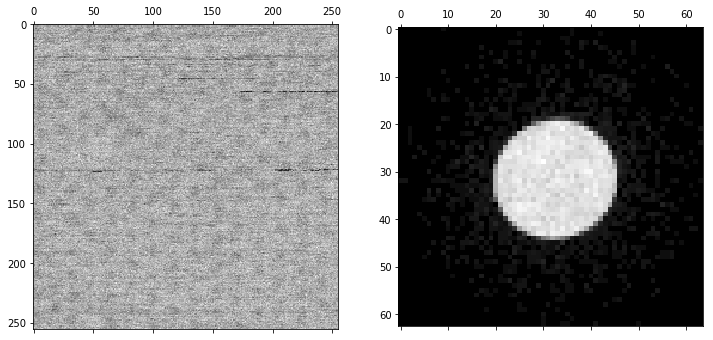

In [105]:
rx,ry = 30,30
power = .5

BF = np.average(dc.data4D,axis=(2,3))
DP = dc.data4D[rx,ry,:,:]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(BF)
ax2.matshow(DP**power)
plt.show()

### Get CBED center and radius

These are used for
1. Calibrating the diffraction plane pixel size
2. Masking the central disk

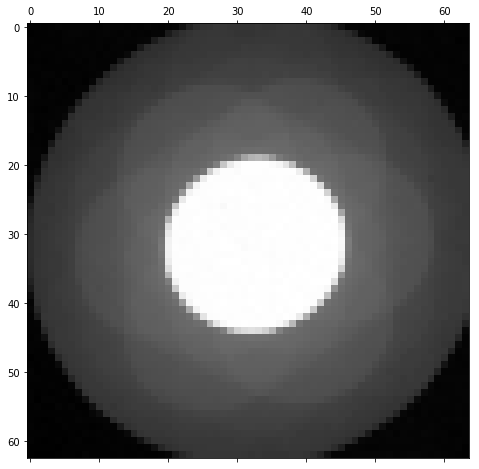

In [106]:
# Get PACBED

power = 0.1

PACBED = np.average(dc.data4D,axis=(0,1))

# Show
fig,ax = plt.subplots(figsize=(8,8,))
ax.matshow(PACBED**power)
plt.show()

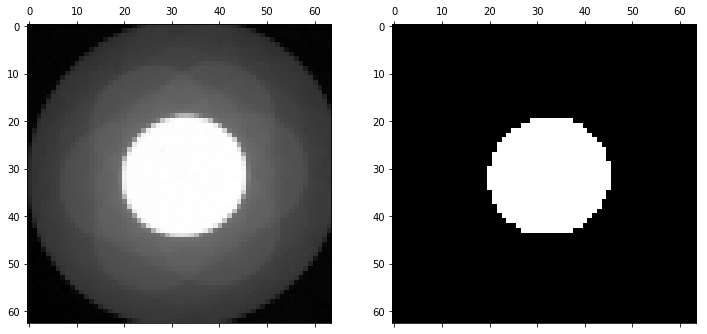

In [107]:
thresh = .5
power=0.1

mask = PACBED > np.max(PACBED)*thresh

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(PACBED**power)
ax2.matshow(mask)
plt.show()

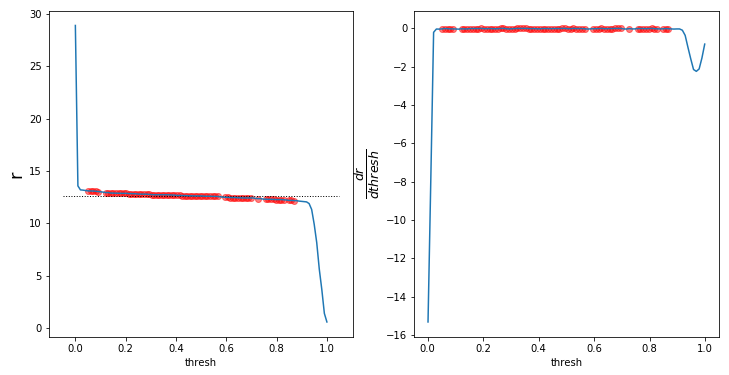

r = 12.624


In [108]:
# Get bright field disk radius

N = 100
thresh_lower = 0.001
thresh_upper = 0.999

thresh_vals = np.linspace(thresh_lower,thresh_upper,N)
r_vals = np.zeros(N)

for i in range(len(thresh_vals)):
    thresh = thresh_vals[i]
    mask = PACBED > np.max(PACBED)*thresh
    r_vals[i] = np.sqrt(np.sum(mask)/np.pi)

dr_dtheta = np.gradient(r_vals)
mask = (dr_dtheta <= 0) * (dr_dtheta >= 2*np.median(dr_dtheta)) 

r = np.average(r_vals[mask])

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(thresh_vals,r_vals)
ax2.plot(thresh_vals,dr_dtheta)
ax1.scatter(thresh_vals[mask],r_vals[mask],color='r',alpha=0.5)
ax2.scatter(thresh_vals[mask],dr_dtheta[mask],color='r',alpha=0.5)
ax1.hlines(r,ax1.get_xlim()[0],ax1.get_xlim()[1],linestyle=':',linewidth=1)
ax1.set_xlabel('thresh')
ax1.set_ylabel('r',size=18)
ax2.set_xlabel('thresh')
ax2.set_ylabel(r'$\frac{dr}{dthresh}$',size=18)
plt.show()

print("r = {:.5}".format(r))

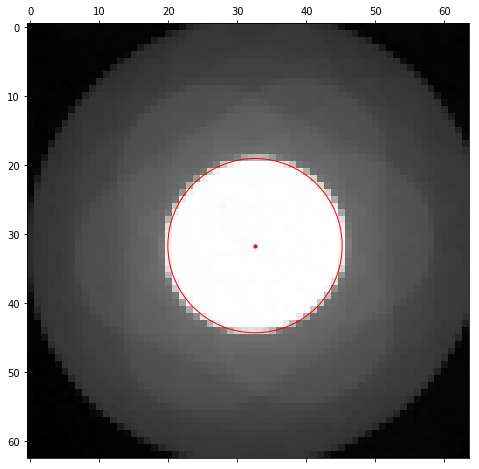

In [109]:
# Get the bright field disk center, and plot

sigma = 10
x0,y0 = py4DSTEM.process.utils.get_CoM(PACBED)

# Show
fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(PACBED**power)
ax.scatter(y0,x0,color='r',s=10)
circle = Circle((y0,x0),r,fill=False,edgecolor='r',linewidth=1)
ax.add_patch(circle)
plt.show()

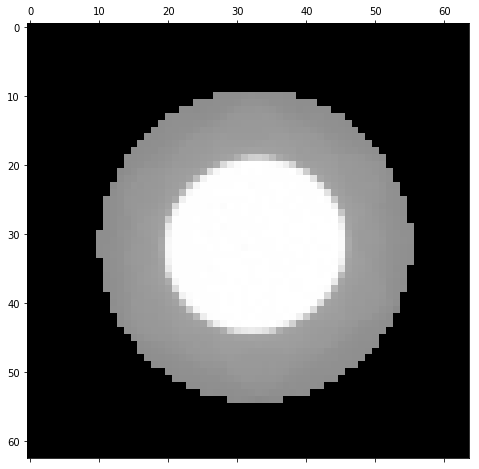

In [110]:
# Get mask and masked coordinates

expand = 10

qy,qx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
qx = qx - x0
qy = qy - y0
qr = np.hypot(qx,qy)
mask = qr < r + expand
qx = mask*qx
qy = mask*qy

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow((mask*PACBED)**power)
plt.show()

### Get centers of mass

In [111]:
# Get CoM shifts

normalize_shifts = True

dxshift = np.zeros((dc.R_Nx,dc.R_Ny))
dyshift = np.zeros((dc.R_Nx,dc.R_Ny))
signal = np.zeros((dc.R_Nx,dc.R_Ny))

for Rx in range(dc.R_Nx):
    for Ry in range(dc.R_Ny):
        DP = dc.data4D[Rx,Ry,:,:]
        signal[Rx,Ry] = np.sum(DP*mask)
        dxshift[Rx,Ry] = np.sum(qx*DP) / signal[Rx,Ry]
        dyshift[Rx,Ry] = np.sum(qy*DP) / signal[Rx,Ry]
        
if normalize_shifts:
    dxshift = dxshift - np.mean(dxshift)
    dyshift = dyshift - np.mean(dyshift)

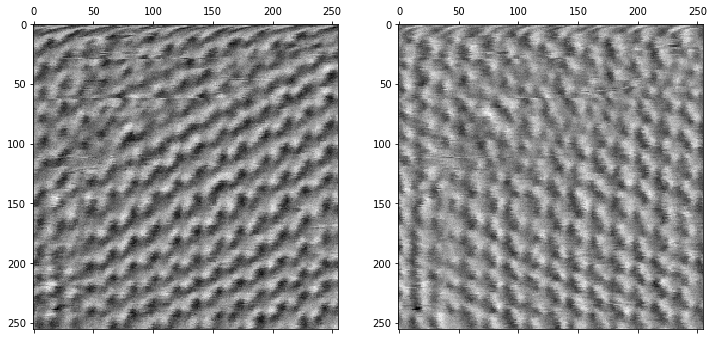

In [112]:
# Show

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(dxshift)
ax2.matshow(dyshift)
plt.show()

In [163]:
dyshift = -dyshift

### Get rotation and flip

In [178]:
# Coordinates

x1 = np.arange(0,dc.Q_Nx-2)
x2 = np.arange(1,dc.Q_Nx-1)
x3 = np.arange(2,dc.Q_Nx-0)
y1 = np.arange(0,dc.Q_Ny-2)
y2 = np.arange(1,dc.Q_Ny-1)
y3 = np.arange(2,dc.Q_Ny-0)

In [179]:
# Cost function coefficients

term1 = np.roll(dxshift,(0,-1),axis=(0,1)) - np.roll(dxshift,( 0,+1),axis=(0,1)) + \
        np.roll(dyshift,(1, 0),axis=(0,1)) - np.roll(dyshift,(-1, 0),axis=(0,1))
term2 = np.roll(dxshift,(1, 0),axis=(0,1)) - np.roll(dxshift,(-1, 0),axis=(0,1)) + \
        np.roll(dyshift,(0, 1),axis=(0,1)) - np.roll(dyshift,( 0,-1),axis=(0,1))

# With flip

term1_f = np.roll( dxshift,(0,-1),axis=(0,1)) - np.roll( dxshift,( 0,+1),axis=(0,1)) + \
          np.roll(-dyshift,(1, 0),axis=(0,1)) - np.roll(-dyshift,(-1, 0),axis=(0,1))
term2_f = np.roll( dxshift,(1, 0),axis=(0,1)) - np.roll( dxshift,(-1, 0),axis=(0,1)) + \
          np.roll(-dyshift,(0, 1),axis=(0,1)) - np.roll(-dyshift,( 0,-1),axis=(0,1))

In [180]:
n_iter = 100
stepSize = 4

thetas = np.zeros(n_iter)
costs = np.zeros(n_iter)
thetas_f = np.zeros(n_iter)
costs_f = np.zeros(n_iter)

theta = 0
for i in range(n_iter):
    thetas[i] = theta
    gradAll = stepSize * (term1*np.cos(theta) + term2*np.sin(theta)) * (-term1*np.sin(theta) + term2*np.cos(theta))
    grad = np.mean(gradAll)
    theta = theta - grad * stepSize
    costs[i] = np.mean((term1*np.cos(theta) + term2*np.sin(theta))**2)

theta = 0
for i in range(n_iter):
    thetas_f[i] = theta
    gradAll = stepSize * (term1_f*np.cos(theta) + term2_f*np.sin(theta)) * (-term1_f*np.sin(theta) + term2_f*np.cos(theta))
    grad = np.mean(gradAll)
    theta = theta - grad * stepSize
    costs_f[i] = np.mean((term1_f*np.cos(theta) + term2_f*np.sin(theta))**2)

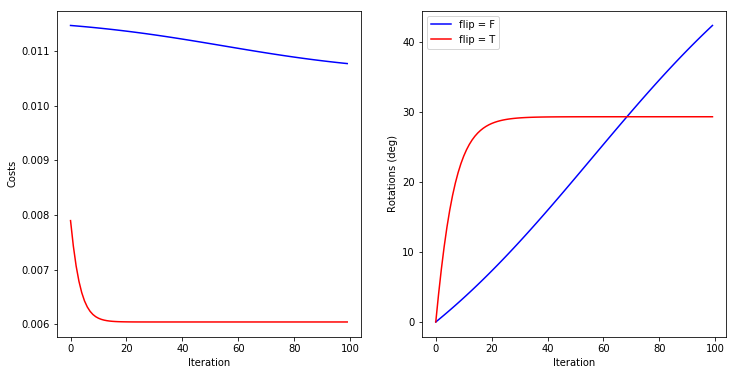

In [182]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(np.arange(len(thetas)),costs,color='b')
ax1.plot(np.arange(len(thetas_f)),costs_f,color='r')
ax2.plot(np.arange(len(thetas)),np.degrees(thetas),color='b',label='flip = F')
ax2.plot(np.arange(len(thetas_f)),np.degrees(thetas_f),color='r',label='flip = T')
ax1.set_ylabel("Costs")
ax1.set_xlabel("Iteration")
ax2.set_ylabel("Rotations (deg)")
ax2.set_xlabel("Iteration")
ax2.legend()
plt.show()

In [183]:
cost_noflip = costs[-1]
cost_flip = costs_f[-1]

if cost_flip < cost_noflip:
    flip = True
    theta_Q_to_R = thetas_f[-1]
else:
    flip = False
    theta_Q_to_R = thetas[-1]
    
print("Rotational offset = {:.4} degrees".format(np.degrees(theta_Q_to_R)))
print("Flip is set to {}".format(flip))

Rotational offset = 29.33 degrees
Flip is set to True


### Reconstruction

In [184]:
# Coordinates

paddingFactor = 2

R_Nx_padded, R_Ny_padded = dc.R_Nx*paddingFactor, dc.R_Ny*paddingFactor

qx_p, qy_p = py4DSTEM.process.utils.make_Fourier_coords2D(R_Nx_padded,R_Ny_padded,pixelSize=1)
qr2_p = qx_p**2 + qy_p**2

In [185]:
# Inverse operators

regLowPass = 100
regHighPass = 0
stepSize = 1

qDen = qr2_p + regHighPass + qr2_p**2 * regLowPass
_ = np.seterr(divide='ignore')
qDen = 1./qDen
qDen[0,0] = 0
_ = np.seterr(divide='warn')
f = 1j * 0.25 * stepSize
qxOp = f*qx_p * qDen
qyOp = f*qy_p * qDen

In [186]:
# Reconstruction

n_iter = 100
stepsize = .5

# Perform rotation and flipping
if not flip:
    dxshift_rot = dxshift*np.cos(theta_Q_to_R) - dyshift*np.sin(theta_Q_to_R)
    dyshift_rot = dxshift*np.sin(theta_Q_to_R) + dyshift*np.cos(theta_Q_to_R)
else:
    dxshift_rot = dxshift*np.cos(theta_Q_to_R) + dyshift*np.sin(theta_Q_to_R)
    dyshift_rot = dxshift*np.sin(theta_Q_to_R) - dyshift*np.cos(theta_Q_to_R)


# Init
imageRecon = np.zeros((R_Nx_padded,R_Ny_padded))
imageUpdate = np.zeros((R_Nx_padded,R_Ny_padded))
error = np.zeros(n_iter)

# Update mask
mask = np.zeros((R_Nx_padded,R_Ny_padded),dtype=bool)
mask[:dc.R_Nx,:dc.R_Ny] = True
maskInv = mask==False

# Perform iterative reconstruction
for i in range(n_iter):
    # Measure current gradient
    dx = (np.roll(imageRecon,(-1,0),axis=(0,1)) - np.roll(imageRecon,(1,0),axis=(0,1))) / 2.
    dy = (np.roll(imageRecon,(0,-1),axis=(0,1)) - np.roll(imageRecon,(0,1),axis=(0,1))) / 2.
    
    # Update using measured values
    dx[mask] -= dxshift_rot.ravel()
    dy[mask] -= dyshift_rot.ravel()
    dx[maskInv] = 0
    dy[maskInv] = 0

    # Calculate reconstruction update
    imageUpdate = np.real(np.fft.ifft2(np.fft.fft2(dx)*qxOp + np.fft.fft2(dy)*qyOp))
    
    # Apply update
    imageRecon += stepsize*imageUpdate
    
    # Estimate error from cost function, RMS deviation of gradients
    dxRecon = (np.roll(imageRecon,(-1,0),axis=(0,1)) - np.roll(imageRecon,(1,0),axis=(0,1))) / 2.
    dyRecon = (np.roll(imageRecon,(0,-1),axis=(0,1)) - np.roll(imageRecon,(0,1),axis=(0,1))) / 2.
    xDiff = dxRecon[mask] - dxshift_rot.ravel()
    yDiff = dyRecon[mask] - dyshift_rot.ravel()
    diff = np.sqrt(np.mean((xDiff - np.mean(xDiff))**2 + (yDiff - np.mean(yDiff))**2))
    error[i] = diff
    
imageRecon = imageRecon[:dc.R_Nx,:dc.R_Ny]

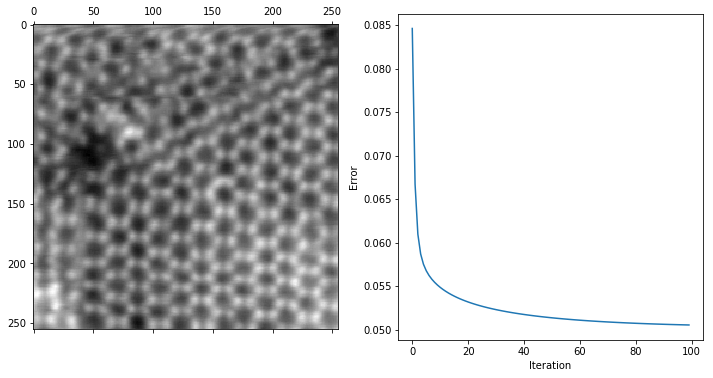

In [187]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(imageRecon)
ax2.plot(np.arange(n_iter),error)
ax2.set_ylabel('Error')
ax2.set_xlabel('Iteration')
plt.show()

### Calibrate

In [ ]:
rsize = [40,40]
keV = 60
alpha = 30.6*1e-3
kalpha = get_wavenumber(keV*1e3)*alpha